# Import

In [1]:
import sys

root_dir = '../../'
if root_dir not in sys.path:
    sys.path.append(root_dir)

import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

from modules import losses, models, samplers, searches, regularizers, evaluators, trainers, datasets

# Dataset

In [2]:
dataset = datasets.ML20m()
n_user = dataset.n_user
n_item = dataset.n_item
train_set, test_set = dataset.get_train_and_test_set()

# device setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_set = torch.LongTensor(train_set).to(device)
test_set = torch.FloatTensor(test_set).to(device)

# Evaluator

In [3]:
# k
ks = [5, 10, 50]

score_function_dict = {
    "Recall"      : evaluators.recall,
    "Unpopularity": evaluators.unpopularity,
    "Unpopularity2": evaluators.unpopularity2,
    "Unpopularity3": evaluators.unpopularity3,
    "F1-score"    : evaluators.f1_score,
    "F1-score2"    : evaluators.f1_score2,
    "F1-score3"    : evaluators.f1_score3
}
userwise = evaluators.UserwiseEvaluator(test_set, score_function_dict, ks)
# coverage = evaluators.CoverageEvaluator(test_set, ks)
# hubness = evaluators.HubnessEvaluator(test_set, ks)

# Sampler

In [4]:
sampler = samplers.BaseSampler(train_set, n_user, n_item, device=device, strict_negative=False)

# Model

In [5]:
# Hyperparameters
lr = 1e-3
n_dim = 10
n_batch = 256
n_epoch = 50
no_progressbar = True

model = models.CollaborativeMetricLearning(n_user, n_item, n_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = losses.SumTripletLoss(margin=1).to(device)
trainer = trainers.BaseTrainer(model, optimizer, criterion, sampler, no_progressbar)

# No Training Result

In [6]:
knn = searches.NearestNeighborhood(model)
trainer.valid(knn, userwise)
re_no_training = trainer.valid_scores.copy()
display(re_no_training)

,Recall@5,Unpopularity@5,Unpopularity2@5,F1-score@5,F1-score2@5,Recall@10,Unpopularity@10,Unpopularity2@10,F1-score@10,F1-score2@10,Recall@50,Unpopularity@50,Unpopularity2@50,F1-score@50,F1-score2@50
0,0.063099,0.925355,9.186255,0.092824,0.120946,0.12606,0.925164,9.184886,0.181066,0.24104,0.5222,0.872172,8.658139,0.554753,0.946755


# Training

In [7]:
# only traing no validation
trainer.fit(n_batch, n_epoch)

# Result

## Base CML

In [8]:
knn = searches.NearestNeighborhood(model)

# Recall
trainer.valid(knn, userwise)
re_base = trainer.valid_scores.copy()
display(re_base)

,Recall@5,Unpopularity@5,Unpopularity2@5,F1-score@5,F1-score2@5,Recall@10,Unpopularity@10,Unpopularity2@10,F1-score@10,F1-score2@10,Recall@50,Unpopularity@50,Unpopularity2@50,F1-score@50,F1-score2@50
0,0.238143,0.742512,4.062799,0.259879,0.395477,0.48648,0.670035,3.591596,0.464163,0.803607,0.899664,0.740461,5.745228,0.796003,1.521786


## CML+MP

In [9]:
search_ranges = [10, 15, 20, 25, 30]

In [10]:
re_mpcmp_li = []
for search_range in search_ranges:
    print(f'search_range={search_range}')
    mp = searches.Mymp(model, search_range)
    trainer.valid(mp, userwise)
    re = trainer.valid_scores.copy()
    display(re)
    re_mpcmp_li.append(re)

search_range=10


,Recall@5,Unpopularity@5,Unpopularity2@5,F1-score@5,F1-score2@5,Recall@10,Unpopularity@10,Unpopularity2@10,F1-score@10,F1-score2@10,Recall@50,Unpopularity@50,Unpopularity2@50,F1-score@50,F1-score2@50
0,0.180256,0.774699,4.580387,0.226864,0.314046,0.455131,0.702251,4.190827,0.453024,0.777137,0.540581,0.865375,8.332184,0.560534,0.975593


search_range=15


,Recall@5,Unpopularity@5,Unpopularity2@5,F1-score@5,F1-score2@5,Recall@10,Unpopularity@10,Unpopularity2@10,F1-score@10,F1-score2@10,Recall@50,Unpopularity@50,Unpopularity2@50,F1-score@50,F1-score2@50
0,0.1291,0.813086,5.220916,0.172774,0.233454,0.413713,0.694814,4.063573,0.431728,0.706336,0.652755,0.838368,7.868684,0.655468,1.173457


search_range=20


,Recall@5,Unpopularity@5,Unpopularity2@5,F1-score@5,F1-score2@5,Recall@10,Unpopularity@10,Unpopularity2@10,F1-score@10,F1-score2@10,Recall@50,Unpopularity@50,Unpopularity2@50,F1-score@50,F1-score2@50
0,0.099227,0.840053,5.72008,0.141231,0.181786,0.329564,0.731279,4.643499,0.375719,0.576547,0.730345,0.815277,7.449296,0.711313,1.305175


search_range=25


,Recall@5,Unpopularity@5,Unpopularity2@5,F1-score@5,F1-score2@5,Recall@10,Unpopularity@10,Unpopularity2@10,F1-score@10,F1-score2@10,Recall@50,Unpopularity@50,Unpopularity2@50,F1-score@50,F1-score2@50
0,0.081235,0.858358,6.093737,0.120239,0.150074,0.272316,0.760898,5.119402,0.328912,0.483326,0.783743,0.79634,7.080356,0.744843,1.391695


search_range=30


,Recall@5,Unpopularity@5,Unpopularity2@5,F1-score@5,F1-score2@5,Recall@10,Unpopularity@10,Unpopularity2@10,F1-score@10,F1-score2@10,Recall@50,Unpopularity@50,Unpopularity2@50,F1-score@50,F1-score2@50
0,0.069528,0.871591,6.382876,0.105493,0.129042,0.232761,0.78381,5.500482,0.292811,0.417248,0.820781,0.780972,6.757517,0.765321,1.447906


### Recall

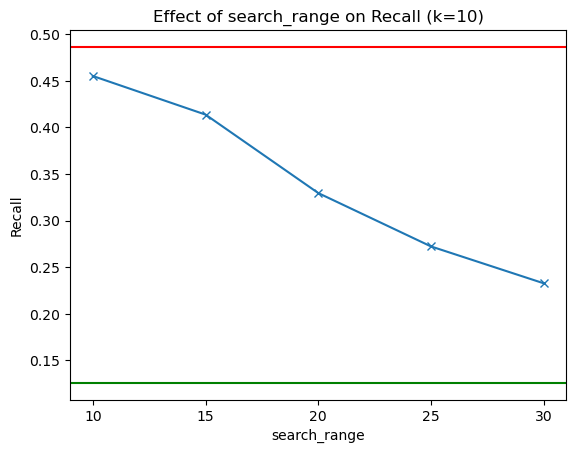

In [16]:
re_recall = []
for re in re_mpcmp_li:
    re_recall.append(re.iloc[-1, 7])
plt.plot(search_ranges, re_recall, marker='x')
plt.xticks(search_ranges)
plt.title('Effect of search_range on Recall (k=10)')
plt.xlabel('search_range')
plt.ylabel('Recall')
plt.axhline(y=re_base.iloc[-1, 7], color='r', linestyle='-')
plt.axhline(y=re_no_training.iloc[-1, 7], color='g', linestyle='-')
plt.show()

### Unpopularity

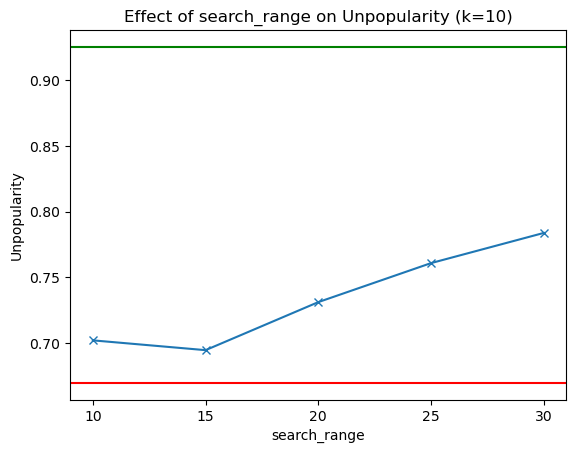

In [17]:
re_unpopularity = []
for re in re_mpcmp_li:
    re_unpopularity.append(re.iloc[-1, 8])
plt.plot(search_ranges, re_unpopularity, marker='x')
plt.xticks(search_ranges)
plt.title('Effect of search_range on Unpopularity (k=10)')
plt.xlabel('search_range')
plt.ylabel('Unpopularity')
plt.axhline(y=re_base.iloc[-1, 8], color='r', linestyle='-')
plt.axhline(y=re_no_training.iloc[-1, 8], color='g', linestyle='-')
plt.show()

### Unpopularity2

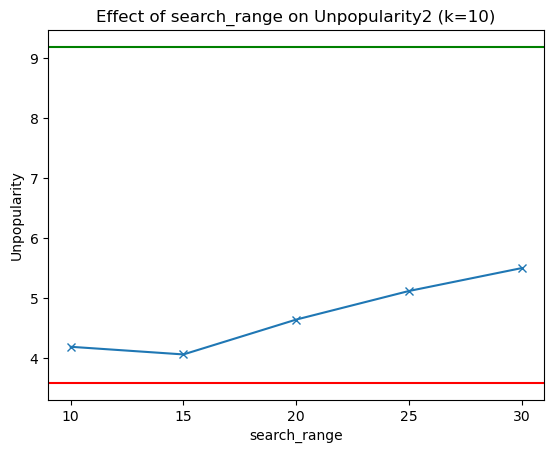

In [19]:
re_unpopularity2 = []
for re in re_mpcmp_li:
    re_unpopularity2.append(re.iloc[-1, 9])
plt.plot(search_ranges, re_unpopularity2, marker='x')
plt.xticks(search_ranges)
plt.title('Effect of search_range on Unpopularity2 (k=10)')
plt.xlabel('search_range')
plt.ylabel('Unpopularity')
plt.axhline(y=re_base.iloc[-1, 9], color='r', linestyle='-')
plt.axhline(y=re_no_training.iloc[-1, 9], color='g', linestyle='-')
plt.show()

### Unpopularity3

In [ ]:
re_unpopularity3 = []
for re in re_mpcmp_li:
    re_unpopularity3.append(re.iloc[-1, 10])
plt.plot(search_ranges, re_unpopularity3, marker='x')
plt.xticks(search_ranges)
plt.title('Effect of search_range on Unpopularity3 (k=10)')
plt.xlabel('search_range')
plt.ylabel('Unpopularity')
plt.axhline(y=re_base.iloc[-1, 10], color='r', linestyle='-')
plt.axhline(y=re_no_training.iloc[-1, 10], color='g', linestyle='-')
plt.show()

### F1-score

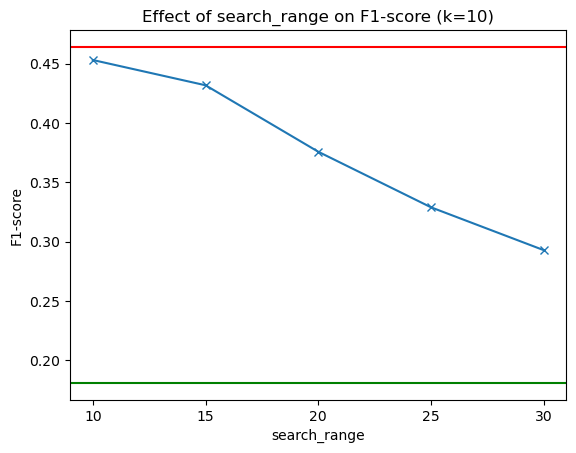

In [20]:
re_f1_score = []
for re in re_mpcmp_li:
    re_f1_score.append(re.iloc[-1, 11])
plt.plot(search_ranges, re_f1_score, marker='x')
plt.xticks(search_ranges)
plt.title('Effect of search_range on F1-score (k=10)')
plt.xlabel('search_range')
plt.ylabel('F1-score')
plt.axhline(y=re_base.iloc[-1, 11], color='r', linestyle='-')
plt.axhline(y=re_no_training.iloc[-1, 11], color='g', linestyle='-')
plt.show()

### F1-score2

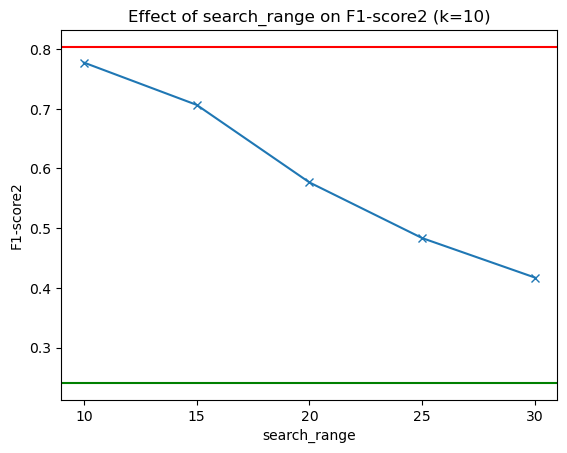

In [23]:
re_f1_score2 = []
for re in re_mpcmp_li:
    re_f1_score2.append(re.iloc[-1, 11])
plt.plot(search_ranges, re_f1_score2, marker='x')
plt.xticks(search_ranges)
plt.title('Effect of search_range on F1-score2 (k=10)')
plt.xlabel('search_range')
plt.ylabel('F1-score2')
plt.axhline(y=re_base.iloc[-1, 11], color='r', linestyle='-')
plt.axhline(y=re_no_training.iloc[-1, 11], color='g', linestyle='-')
plt.show()

### F1-score3

In [ ]:
re_f1_score3 = []
for re in re_mpcmp_li:
    re_f1_score3.append(re.iloc[-1, 12])
plt.plot(search_ranges, re_f1_score3, marker='x')
plt.xticks(search_ranges)
plt.title('Effect of search_range on F1-score3 (k=10)')
plt.xlabel('search_range')
plt.ylabel('F1-score3')
plt.axhline(y=re_base.iloc[-1, 12], color='r', linestyle='-')
plt.axhline(y=re_no_training.iloc[-1, 12], color='g', linestyle='-')
plt.show()